In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from os.path import exists
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import patsy
import re
from collections import defaultdict
from base64 import b64encode
from IPython.core.pylabtools import print_figure 
from matplotlib._pylab_helpers import Gcf
from IPython.core.display import display, HTML
import warnings

## Question 0 - R-Squared Warmup
In this question you will fit a model to the ToothGrowth data used in the
notes on Resampling and Statsmodels-OLS. Read the data, log transform tooth
length, and then fit a model with indpendent variables for supplement type,
dose (as categorical), and their interaction. Demonstrate how to compute the
R-Squared and Adjusted R-Squared values and compare your compuations to the
attributes (or properties) already present in the result object.

In [2]:
file = 'tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    tg_data = tooth_growth.data
    tg_data.to_feather(file)

In [3]:
# Log transform the len and transform supplement to one-hot variable-----------
tg_data['log_len']= tg_data[['len']].transform(np.log)
tg_data['OJ'] = pd.get_dummies(tg_data['supp'])['OJ']

In [4]:
# Transform the type of dose to categorical------------------------------------
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])

In [5]:
# Linear regression with supp, dose and their interaction----------------------
mod = smf.ols('log_len ~ OJ*dose_cat', data=tg_data)
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.775   
Dependent Variable:  log_len          AIC:                3.4775  
Date:                2021-11-05 10:42 BIC:                16.0436 
No. Observations:    60               Log-Likelihood:     4.2612  
Df Model:            5                F-statistic:        41.69   
Df Residuals:        54               Prob (F-statistic): 2.34e-17
R-squared:           0.794            Scale:              0.056441
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           2.0208   0.0751 26.8989 0.0000  1.8702  2.1715
dose_cat[T.1.0]     0.7893   0.1062  7.4294 0.0000  0.5763  1.0024
dose_cat[T.2.0]     1.2273   0.1062 11.5513 0.0000  1.0143  1.4403
OJ                  0.5118   0.1062  4.8171 0.0000  0.2988  0.7248
OJ:dose_cat[T.1.0] -0.2148   0.1503 -1.4297 0.1586 -0.5161  0.0864
OJ:dose_cat[T.2.0] -0.5041   0.1503 -3.3551 0.0015 -0.8054 -0.2029
------------------------------------------------------------------
Omnibus:              0.136         Durbin-Watson:           1.862
Prob(Omnibus):        0.934         Jarque-Bera (JB):        0.039
Skew:                 -0.058        Prob(JB):                0.981
Kurtosis:             2.953         Condition No.:           10   
==================================================================

"""

$$R^2 = 1 - \frac{(\hat{y}_i-y_i)^2}{(y_i-\bar{y})^2}$$
where $\bar{y}=\frac{1}{n}\sum_{i=1}^{n}y_i$, $\hat{y}_i=\sum_{j=1}^{n}x_{ij}
\beta_{j}+\epsilon_i$

In [6]:
# Calculate R-square and compare R-square in the model-------------------------
rss = ((np.dot(mod.exog, res.params)-mod.endog)**2).sum()
tss = ((mod.endog.mean() - mod.endog)**2).sum()
R_square = 1 - rss/tss
assert(np.round(R_square, 10)== np.round(res.rsquared, 10))

$$\mbox{Adj} \ R^2= 1 - \frac{(1 - R^2)(n-1)}{n-(p+1)}$$

Where $n$ is the number of observations and $p$ is the number of predictors.

In [7]:
# Calculate  Adj R-square and compare with Adj R-square in the model-----------
Adj_r = 1 - np.divide(mod.nobs-1, mod.df_resid)*(1-res.rsquared)
assert(Adj_r == res.rsquared_adj)

## Question 1 - NHANES Dentition
### Part a)
Pick a single tooth (OHXxxTC) and model the probability that a permanent
tooth is present (look up the corresponding statuses) as a function of age
using logistic regression. For simplicity, assume the data are iid and ignore
the survey weights and design. Use a B-Spline basis to allow the probability
to vary smoothly with age. Perform model selection using AIC or another
method to choose the location of knots and the order of the basis (or just
use order=3 and focus on knots).

In [8]:
demo = pd.read_pickle('demographic.pickle') 
ohx = pd.read_pickle('oral health - dentition.pickle')

In [9]:
ohx0 = pd.merge(ohx, demo.loc[:,['id', 'gender', 'age', 'race']],
                how='left', on='id')
ohx0['age'] = ohx0['age'].astype(int)
dep_vars =  {'ohx01tc': {'Permanent tooth present': 1, 
                         'Tooth not present': 0, 
                         'Permanent dental root fragment present': 0,
                         'Primary tooth present': 0,
                         'Dental Implant': 0,
                         'Could not assess': np.nan}}
gender_col = {'Female':0, 'Male':1}
race_col = {'Mexican American':1,
            'Other Hispanic':2,
            'Non-Hispanic White':3,
            'Non-Hispanic Black':4,
            'Non-Hispanic Asian':5,
            'Other/Multiracial':7
            }
ohx0['race'] = pd.Categorical(ohx0['race'].replace(race_col))
ohx0['gender'] = pd.Categorical(ohx0['gender'].replace(gender_col))
for c in dep_vars.keys():
    ohx0[c] = ohx0[c].replace(dep_vars[c])

Limit the analyses to those age 12 and older so that singular matrix will not
happen during the logistic regression.

In [10]:
ohx0 = ohx0.query('age>=12')

In [11]:
ohx0 = ohx0.dropna()

Apply logistic regression to independent variable age and dependent variable
"ohx01tc".

In [12]:
mod0 = smf.logit('ohx01tc ~ age', data=ohx0)
res0 = mod0.fit(disp=True)
res0.summary()

Optimization terminated successfully.
         Current function value: 0.503298
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ohx01tc   No. Observations:                25311
Model:                          Logit   Df Residuals:                    25309
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Nov 2021   Pseudo R-squ.:                0.002327
Time:                        10:42:44   Log-Likelihood:                -12739.
converged:                       True   LL-Null:                       -12769.
Covariance Type:            nonrobust   LLR p-value:                 1.263e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1235      0.035    -32.139      0.000      -1.192      -1.055
age           -0.0058      0.001     -7.681      0.000      -0.007      -0.004
==============================================================================
"""

This plot is mainly to display the correlation between age and the
probability the specific tooth is permanent tooth of a person. It will give
us a straightword insight on how the probability varies with age, which will
help us to select knots in the following step.

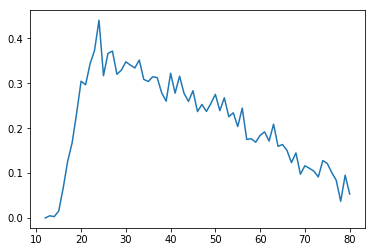

In [13]:
plt.plot(ohx0.groupby(['age'])['ohx01tc'].mean())

In this step, I am going to use B-spline basis to allow the probability vary
smoothly with age. My strategy fot knots selection is as following:
* Assume there is only one knot in the model and traverse all the points from
12-79 to select the point with the minimal AIC, denote as $P_1$.
* Assume there are two knots in the model and the first knot is $P_1$, select
another knot from the rest of points $\in [12,P_1)\cup(P_1,79]$ with the
minal AIC and denote as $P_2$. The knots of this step is $[P_1, P_2]$.
* Approximately repeat the above step with $k = 3,4,5,...,n$ knots and find
the best point $P_n$ adding to the former model.
* Compare the AIC of the best model we select from  knots with
$k = 1,2,...,n$ and finalize the model with the best AIC

I set $n=10$ in my model selection code, which I believe is suifficient to
find the best model with knots. As for the order of the B-spline basis, I set
the order to be 3 because it is the minimal order that can allow the first
and second derivate continues. In the following code, I calculate the minimal
AIC and its corresponding knots.

In [137]:
age = [i for i in range(13,80)]
val = []
for i in range(10):
    aic = 30000
    if i != 0:
        age.remove(val[-1])
    for m in age:
        try:     
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                knot = []
                x = ohx0['age']
                vall = val.copy()
                vall.append(m)
                knot.extend(vall)
                knot = [str(x) for x in knot]
                knots = ','.join(knot)
                y = patsy.dmatrix("bs(x, knots = ["
                                  + knots +
                                  "], degree=3, include_intercept=False)-1",
                                  {"x": x}, return_type='dataframe')
                mod0 = smf.logit('ohx01tc ~ y', data=ohx0)
                res0 = mod0.fit(disp=False)
                if res0.aic<aic:
                    aic = res0.aic
                    num = m
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print(
                    'knots = [{0:d}], Singular matrix in regression'.format(m)
                )
            else:
                raise
    val.append(num)
    print(val)
    print(aic)

[25]
23190.32691353661
[25, 79]
23190.54977911647
[25, 79, 78]
23191.27320459819
[25, 79, 78, 77]
23188.86848682841
[25, 79, 78, 77, 66]
23189.27541852822
[25, 79, 78, 77, 66, 74]
23189.847346631985
[25, 79, 78, 77, 66, 74, 61]
23189.84314883377
[25, 79, 78, 77, 66, 74, 61, 18]
23190.959770538764
[25, 79, 78, 77, 66, 74, 61, 18, 16]
23191.028797413142
[25, 79, 78, 77, 66, 74, 61, 18, 16, 24]
23190.018191839663


According to the result above, the best model with knots is
$[25, 79, 78, 77]$. But as for this kind of knots, I find most of the knots
located at the tail of the data, and I still want to add some knot at the
middle range of the data. Therefore I find when knots =$[25, 79, 78, 77, 66]$
, the AIC is almost the same as the best model. But with knot=$66$ disperse
the distribution of knots. As a result, I do believe
knots =$[25, 79, 78, 77, 66]$ is my best result of knots selection. Here is
the final model and the summary of the regression.

In [14]:
x = ohx0['age']
y = patsy.dmatrix(
    "bs(x, knots = [25,79,78,77,66], degree=3, include_intercept=False)-1",
    {"x": x}, return_type='dataframe'
)
mod_best = smf.logit('ohx01tc ~ y', data=ohx0)
res_best = mod_best.fit(disp=True)
res_best.summary()

Optimization terminated successfully.
         Current function value: 0.457731
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ohx01tc   No. Observations:                25311
Model:                          Logit   Df Residuals:                    25302
Method:                           MLE   Df Model:                            8
Date:                Fri, 05 Nov 2021   Pseudo R-squ.:                 0.09265
Time:                        10:42:51   Log-Likelihood:                -11586.
converged:                       True   LL-Null:                       -12769.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.7541      0.321    -24.186      0.000      -8.382      -7.126
y[0]           7.4348      0.384     19.353      0.000       6.682       8.188
y[1]           6.8758      0.287     23.939      0.000       6.313       7.439
y[2]           6.7454      0.383     17.623      0.000       5.995       7.496
y[3]           5.5051      0.319     17.265      0.000       4.880       6.130
y[4]           5.5964      0.421     13.298      0.000       4.772       6.421
y[5]          -0.9849      2.768     -0.356      0.722      -6.409       4.439
y[6]          20.5784      6.485      3.173      0.002       7.869      33.288
y[7]           4.8800      0.344     14.200      0.000       4.206       5.554
==============================================================================
"""

According to the result, we can find that the p-value of all the predictors
is signifiacnt under the 95% confidence level, which indicate that all the
variables we include in the regression do have a significant impact on the
reponse.

In [15]:
res_best.aic

23189.27541852822

In the next step, we try to include the information in the demographics table
to make the prediction more reliable. In order to select the variables from
demographics data, let us first consider the realistic meaning of the
logistic regression we do. Generally speaking, we predict the probability of
a tooth is a permanent tooth. This probability is apperantly influenced by
age, but it is also resonable that the probability is effected by gender and
race because such probability is a kind of physiological phenomenon and will
relate with the gender and race. Therefore, I include gender and race
independently in the model and also include both of them in the model. Here
is the results in terms of these three models.

In [16]:
mod_gender = smf.logit('ohx01tc ~ y+gender', data=ohx0)
res_gender = mod_gender.fit(disp=False)
mod_race = smf.logit('ohx01tc ~ y+race', data=ohx0)
res_race = mod_race.fit(disp=False)
mod_comb = smf.logit('ohx01tc ~ y+gender+race', data=ohx0)
res_comb = mod_comb.fit(disp=False)
pd.DataFrame([['age', res_best.aic], ['age, gender', res_gender.aic],
              ['age, race', res_race.aic],
              ['age, gender, race', res_comb.aic]],
             columns=['Variables', 'AIC'])

,Variables,AIC
0,age,23189.275419
1,"age, gender",23015.474486
2,"age, race",22367.211104
3,"age, gender, race",22169.938989


According to the result, we find that the AIC of the model is the smallest
when include variables gender and race. Therefore, if I take AIC as the
evaluation standard, my final model include three variables which are
**age(smooth), gender and race**.

### part b)

According to the discussion above, I pick the knots = $[25,79,78,77,66]$ and
include variables "gender" and "race" in demographic data.

In [17]:
ohx_new = pd.merge(ohx, demo.loc[:,['id', 'age', 'race', 'gender']],
                   how='left', on='id')
ohx_new['age'] = ohx_new['age'].astype(int)
tc = {'Permanent tooth present': 1, 
      'Tooth not present': 0, 
      'Permanent dental root fragment present': 0,
      'Primary tooth present': 0,
      'Dental Implant': 0,
      'Could not assess': np.nan}
ohx_new['race'] = pd.Categorical(ohx_new['race'].replace(race_col))
ohx_new['gender'] = pd.Categorical(ohx_new['gender'].replace(gender_col))

In [18]:
column = r'ohx\d\dtc'
columns_tc = [m for m in ohx0.columns if re.search(column,m) != None]

In [19]:
for col in columns_tc:
    ohx_new[col] = ohx_new[col].replace(tc)

In [20]:
ohx_new = ohx_new.query('age>=12')

In [21]:
result = ohx_new.copy()
for col in columns_tc:
    ohx_test = result.loc[:,['id', 'age','gender', 'race', col]]
    ohx_test = ohx_test.dropna()
    x = ohx_test['age']
    y = patsy.dmatrix(
      "bs(x, knots=[25, 79, 78, 77, 66], degree=3, include_intercept=False)-1",
      {"x": x}, return_type='dataframe')
    mod = smf.logit('{0:s}~y + gender + race'.format(col), data=ohx_test)
    res = mod.fit(disp=False)
    ohx_test[col] = mod.predict(params=res.params, exog=mod.exog)
    ohx_test = ohx_test.loc[:,['id', col]]
    result = result.drop(columns=[col])
    result = pd.merge(result, ohx_test, how='left', on='id')

In [22]:
columns_new = ['id', 'age', 'race'] + columns_tc
pred = result.loc[:,columns_new]
pred = pred.dropna()

In [23]:
table = pred.head(100)

In [24]:
cap = """
<b> Table 1. </b> <em>Predicted probability of a tooth is a permanent tooth in 
terms of age.</em> The predicted values are designed to retain 6 decimal 
places. This table only shows the first 100 predicted data because printing all
 the datas in the HTML form is too time-consuming.
"""
t1 = table.to_html(index=True)
t1 = t1.rsplit('\n')
t1.insert(1, cap)
tab1 = ''
for i, line in enumerate(t1):
    tab1 += line
    if i < (len(t1) - 1):
        tab1 += '\n'

In [25]:
display(HTML(tab1))

,id,age,race,ohx01tc,ohx02tc,ohx03tc,ohx04tc,ohx05tc,ohx06tc,ohx07tc,ohx08tc,ohx09tc,ohx10tc,ohx11tc,ohx12tc,ohx13tc,ohx14tc,ohx15tc,ohx16tc,ohx17tc,ohx18tc,ohx19tc,ohx20tc,ohx21tc,ohx22tc,ohx23tc,ohx24tc,ohx25tc,ohx26tc,ohx27tc,ohx28tc,ohx29tc,ohx30tc,ohx31tc,ohx32tc
0,62161,22,3,0.247704,0.985673,0.978646,0.990245,0.931553,0.993041,0.984112,0.993906,0.992247,0.985900,0.993286,0.930226,0.988764,0.978503,0.986136,0.261300,0.298859,0.980308,0.968341,0.985780,0.941986,0.997612,0.995120,0.994562,0.994849,0.993957,0.997770,0.945241,0.987911,0.972468,0.981881,0.283736
1,62163,14,5,0.010590,0.953398,0.998344,0.983274,0.962836,0.980185,0.994646,0.999269,0.999093,0.995134,0.981380,0.968037,0.983774,0.997310,0.954770,0.010664,0.027398,0.972985,0.995323,0.971515,0.968467,0.994409,0.997595,0.998252,0.996321,0.996571,0.994849,0.967132,0.976663,0.995351,0.969237,0.026809
2,62164,44,3,0.124048,0.810001,0.846944,0.841904,0.807565,0.927513,0.912408,0.924685,0.927726,0.911631,0.927615,0.804934,0.844522,0.834880,0.797738,0.128850,0.149295,0.783990,0.766704,0.887309,0.888333,0.970990,0.969818,0.964857,0.964805,0.967426,0.968684,0.890124,0.883225,0.772694,0.793388,0.157404
3,62165,14,4,0.007324,0.900180,0.995995,0.953421,0.932959,0.957930,0.990001,0.998745,0.998399,0.990501,0.964162,0.941345,0.952135,0.993609,0.899337,0.008216,0.021794,0.929238,0.987097,0.950177,0.961305,0.990669,0.997102,0.997893,0.995894,0.995973,0.991098,0.955210,0.954075,0.987004,0.926807,0.020605
4,62169,21,5,0.447388,0.991775,0.985926,0.994447,0.949413,0.995957,0.990525,0.995812,0.994711,0.991828,0.996169,0.947534,0.994243,0.985094,0.991969,0.438093,0.493685,0.988551,0.975621,0.990472,0.950758,0.998558,0.996053,0.995678,0.995417,0.994785,0.998722,0.953092,0.992405,0.978042,0.988219,0.481810
5,62170,15,7,0.018460,0.939955,0.993817,0.970943,0.933859,0.972098,0.986986,0.998039,0.997434,0.988892,0.970800,0.936765,0.969471,0.992699,0.946579,0.022694,0.045713,0.956016,0.987887,0.958421,0.948946,0.990426,0.994906,0.996239,0.993739,0.993369,0.991483,0.942707,0.966866,0.989023,0.955468,0.041266
6,62171,14,1,0.011759,0.943397,0.997933,0.976221,0.962017,0.976283,0.993413,0.999136,0.998888,0.994008,0.978950,0.965523,0.975335,0.996641,0.949552,0.012550,0.029990,0.957538,0.993886,0.973377,0.976716,0.994897,0.997891,0.998307,0.996677,0.997227,0.994829,0.973530,0.975838,0.994219,0.960438,0.029786
7,62172,43,4,0.306436,0.743966,0.742589,0.766478,0.778145,0.910117,0.891370,0.887562,0.895360,0.890480,0.916472,0.772675,0.769104,0.729131,0.729954,0.319700,0.356153,0.667888,0.590999,0.867145,0.891482,0.968261,0.963888,0.956706,0.957263,0.960539,0.965444,0.884627,0.857031,0.598135,0.673390,0.367423
8,62174,80,3,0.043548,0.337762,0.365995,0.414512,0.437056,0.522447,0.467959,0.486504,0.488960,0.473179,0.514900,0.426844,0.403314,0.384524,0.348054,0.035849,0.063920,0.339082,0.352398,0.485936,0.591413,0.673020,0.614936,0.582825,0.583840,0.612330,0.666287,0.593621,0.489435,0.366694,0.358564,0.074457
9,62176,34,3,0.152449,0.914479,0.931217,0.932597,0.876735,0.971294,0.961280,0.971805,0.972317,0.960735,0.971775,0.876106,0.929515,0.923048,0.911681,0.160375,0.177514,0.892882,0.878137,0.948234,0.923722,0.990781,0.989547,0.987797,0.987950,0.987861,0.989804,0.926062,0.947678,0.884697,0.898523,0.181287


### part c)

Use the result above, I can calculate the mean probability that a specific
tooth is permanent of the perople with the same age.

In [26]:
result = pred.groupby(['age']).mean().drop(columns=['id'])

Make the plots.


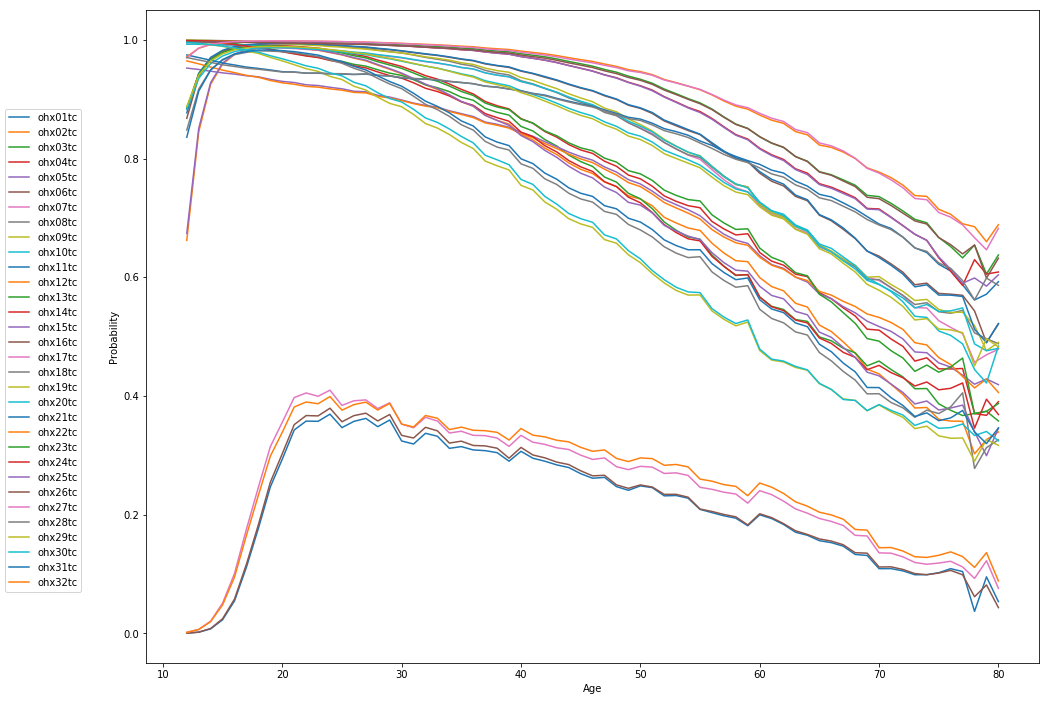

In [27]:
fig0= plt.figure()
fig0.set_size_inches(16, 12)
x = [i for i in range(12,81,1)]
_ = plt.plot(x, result)
_ = fig0.legend([j for j in result.columns], loc='center left')
_ = plt.xlabel('Age') 
_ = plt.ylabel('Probability')
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 1.</b> 
<em>The plot of predicted probability of a permanent tooth with age(12-80).
</em><br> <img src='%s'> <br>
"""
% image_data
)


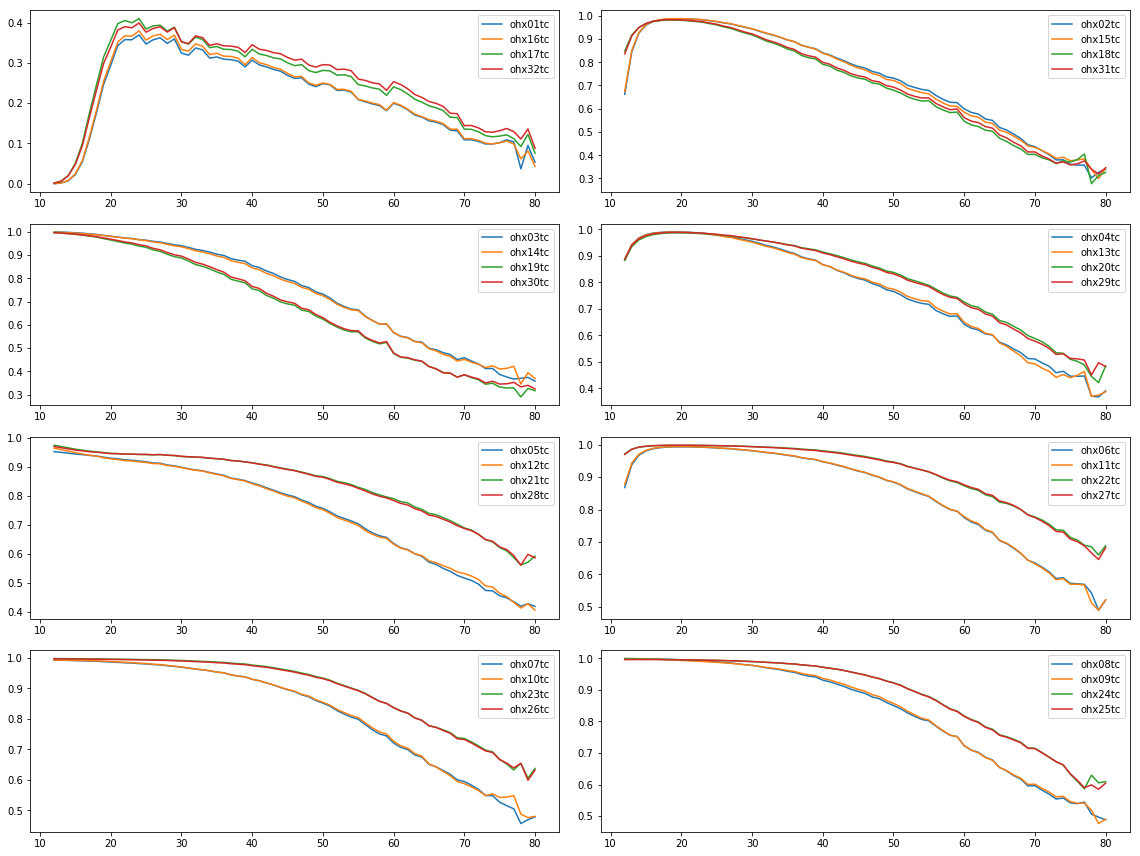

In [28]:
fig0, ax0 = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False)
fig0.set_size_inches(16, 12)
fig0.tight_layout() 
x = [i for i in range(12,81,1)]
for i in range(8):
    lst = [result.columns[i], result.columns[15-i], 
           result.columns[16+i], result.columns[-i-1]]
    ax0[i//2,i%2].plot(x, result.loc[:,lst])
    ax0[i//2,i%2].legend(lst, loc='upper right')
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 2.</b> 
<em>The plot of predicted probability of a permanent tooth with age(12-80).
</em>The subplot display the information of every four teeth. The select of 
teeth in one specific subplot is according to the universal numbering system.
<br> <img src='%s'> <br>
"""
% image_data
)

F:\python\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
F:\python\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]



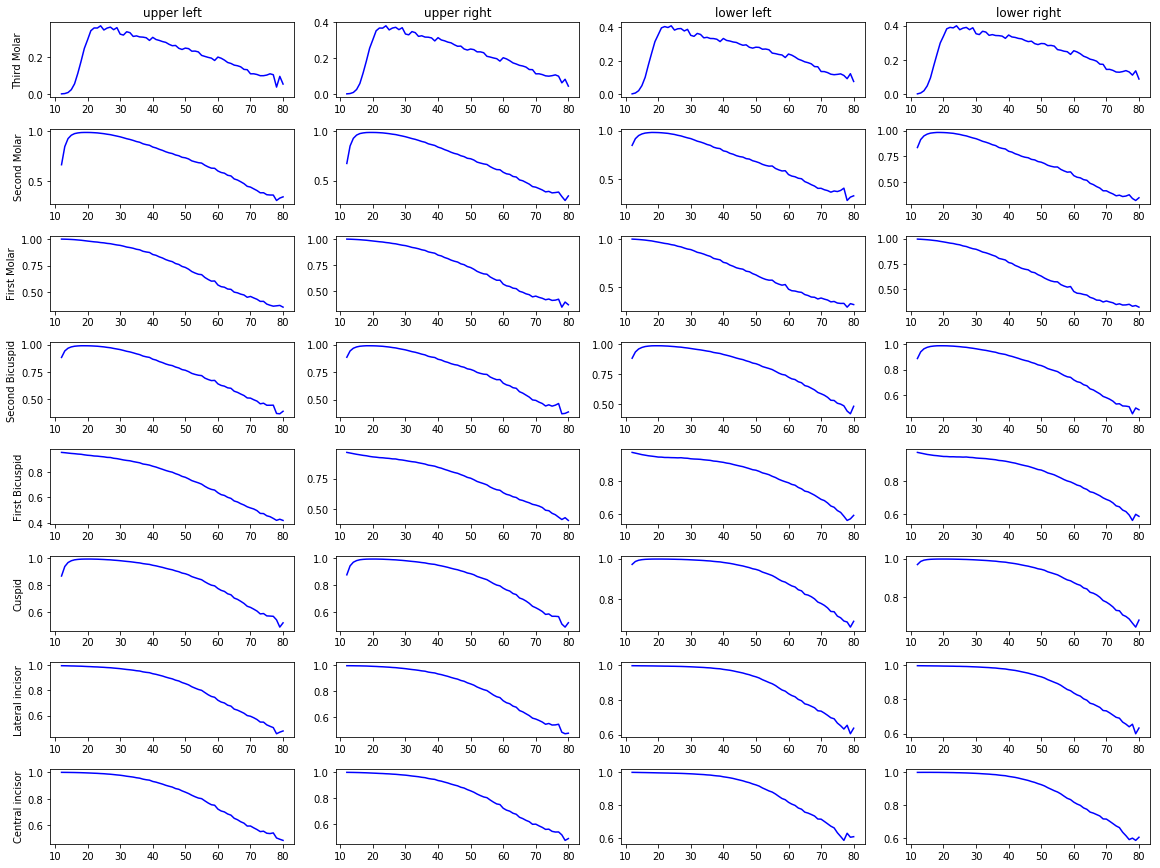

In [29]:
fig0, ax0 = plt.subplots(nrows=8, ncols=4, sharex=False, sharey=False)
fig0.set_size_inches(16, 12)
fig0.tight_layout() 
x = [i for i in range(12,81,1)]
lst = []
ylab = ['Third Molar', 'Second Molar', 'First Molar', 'Second Bicuspid',
        'First Bicuspid', 'Cuspid', 'Lateral incisor', 'Central incisor']
for i in range(8):
    lst.extend([result.columns[i], result.columns[15-i], 
           result.columns[16+i], result.columns[-i-1]])
    
for i in range(32):
    ax0[i//4,i%4].plot(x, result.loc[:,lst[i]], color = 'blue')
    #ax0[i//4,i%4].legend(lst[i], loc='upper right', fontsize = 'medium')
    if i % 4 == 0:
        ax0[i//4,0].set_ylabel(ylab[i//4])
ax0[0,0].set_title('upper left')
ax0[0,1].set_title('upper right')
ax0[0,2].set_title('lower left')
ax0[0,3].set_title('lower right')

fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 3.</b> 
<em>The plot of predicted probability of a permanent tooth with age(12-80).
</em> The subplot display the information of each tooth. The select of 
teeth in specific row and column is based on the universal numbering
system.
<br> <img src='%s'> <br>
"""
% image_data
)

## Question 2 - Hosmer-Lemeshow Calibration Plot

Make the prediction for my best model.

In [30]:
ohx0['est'] = mod_comb.predict(params=res_comb.params, exog=mod_comb.exog)
new = ohx0.loc[:,['ohx01tc','age','est']]

Sort the data according to the fitted value.

In [31]:
new.sort_values(['est'],inplace=True)

Split the data into deciles based on the fitted probabilities.

In [32]:
sub_df = {}
for i in range(10):
    if i != 9:
        sub_df[i] = new.iloc[2531*i : 2531*i + 2531]
    else:
        sub_df[i] = new.iloc[2531*i :]

Compute the observed proportion of cases with a permanent tooth present and
the expected proportion found by averaging the probabilities.

In [33]:
obs = []
est = []
for i in range(10):
    obs_sub = sub_df[i]['ohx01tc'].sum()/sub_df[i]['ohx01tc'].count()
    est_sub = sub_df[i]['est'].mean()
    obs.append(obs_sub)
    est.append(est_sub)

Make the Hosmer-Lemeshow Calibration Plot.


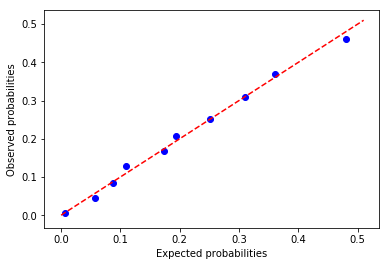

In [34]:
fig0 = plt.figure()
fig0.tight_layout() 
_ = plt.scatter(obs, est, color='blue')
_ = plt.plot([0,0.51],[0,0.51], color='red', linestyle='dashed')
_ = plt.xlabel('Expected probabilities') 
_ = plt.ylabel('Observed probabilities')
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 4.</b> 
<em>Scatter plot of observed probabilities versus expected probabilities.</em>
The x axis represent the expected probability calculated from the origin data,
the y axis represnt the observed probability according to the predicted value 
of logistic regression. The plot also include a line through the origin with 
slope 1 as a guide.<br> <img src='%s'> <br>
"""
% image_data
)

**Comment:** Most of the plots approximately fall on the line with slope
equal to 1, but there are still some plots fall above or below the line. To
conclude, I believe that the model I selected is considered well-calibrated.